Copyright 2023 Google LLC

Use of this source code is governed by an MIT-style
license that can be found in the LICENSE file or at
https://opensource.org/licenses/MIT.

# Instructions
Please run the following cells sequentially
1. (Optional) Running 1b adds semantic labels and requires addtional resources (default to a second GPU).
* The function relies on an additonal image captioning model, e.g., BLIP.  
* The labels are nouns, extracted from the generated caption. 
* It merge masks sharing the same label. 
2. Add your own image and update ``image_path`` variable. 
3. Feel free to play with DiffSeg hyper-parameters such as the ``KL_THRESHOLD``.

In [1]:
import os
import requests
os.environ['http_proxy'] = "http://127.0.0.1:7891"
os.environ['https_proxy'] = "http://127.0.0.1:7891"
response = requests.get('http://www.google.com')
print(response.status_code)

200


# Import

In [2]:
import tensorflow as tf
from PIL import Image
import nltk
from transformers import AutoProcessor, TFBlipForConditionalGeneration
from keras_cv.src.models.stable_diffusion.image_encoder import ImageEncoder
from third_party.keras_cv.stable_diffusion import StableDiffusion 
from third_party.keras_cv.diffusion_model import SpatialTransformer
from diffseg.utils import process_image, augmenter, vis_without_label, semantic_mask
from diffseg.segmentor import DiffSeg

is_noun = lambda pos: pos[:2] == 'NN'
!nvidia-smi
nltk.download('all')

2024-09-17 19:14:55.003462: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-17 19:14:55.041763: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-17 19:14:55.041795: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-17 19:14:55.041821: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-17 19:14:55.049064: I tensorflow/core/platform/cpu_feature_g

Using TensorFlow backend
Tue Sep 17 19:14:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.146.02             Driver Version: 535.146.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:18:00.0 Off |                  N/A |
| 39%   38C    P2              80W / 350W |  22723MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+

2024-09-17 19:14:58.057940: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22439 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:18:00.0, compute capability: 8.6
2024-09-17 19:14:58.058464: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22453 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:3b:00.0, compute capability: 8.6
2024-09-17 19:14:58.058853: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 16392 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:86:00.0, compute capability: 8.6
2024-09-17 19:14:58.059265: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 22453 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090

True

# 1. Initialize SD Model

In [3]:
# Inialize Stable Diffusion Model on GPU:0 
with tf.device('/GPU:0'):
  image_encoder = ImageEncoder()
  vae=tf.keras.Model(
            image_encoder.input,
            image_encoder.layers[-1].output,
        )
  model = StableDiffusion(img_width=512, img_height=512)
blip = None

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


# 1b. Initialize BLIP (optional)

In [4]:
# Optionally initalize a BLIP captioning model on GPU:1
with tf.device('/GPU:1'):
    processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    blip = TFBlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

2024-09-17 19:15:05.748477: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-09-17 19:15:05.839231: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-09-17 19:15:06.090664: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
All model checkpoint layers were used when initializing TFBlipForConditionalGeneration.

All the layers of TFBlipForConditionalGeneration were initialized from the model checkpoint at Salesforce/blip-image-captioning-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBlipForConditionalGeneration for predictions without further training.


# 2. Run Inference on Real Images

In [5]:
# The first time running this cell will be slow
# because the model needs to download and loads pre-trained weights.

image_path = "./images/apple.jpg" # Specify the path to your image

if blip is not None:
  with tf.device('/GPU:1'):
    inputs = processor(images=Image.open(image_path), return_tensors="tf")
    out = blip.generate(**inputs)
    prompt = processor.decode(out[0], skip_special_tokens=True)
    print(prompt)
else:
  prompt = None

with tf.device('/GPU:0'):
  images = process_image(image_path)
  images = augmenter(images)
  latent = vae(tf.expand_dims(images, axis=0), training=False)
  images, weight_64, weight_32, weight_16, weight_8, x_weights_64, x_weights_32, x_weights_16, x_weights_8 = model.text_to_image(
    prompt,
    batch_size=1,
    latent=latent,
    timestep=300
  )  # single step (timestep=300) diffusion to attain self-attention maps
  

/home/gpu/anaconda3/envs/diffseg/lib/python3.9/site-packages/transformers/generation/tf_utils.py:838: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length.  recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


apples in a wooden box


2024-09-17 19:15:11.969000: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700


A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 8799ff9763de13d7f30a683d653018e114ed24a6a819667da4f5ee10f9e805fe so we will re-download the data.
198180272/198180272 [==============================] - 25s 0us/step


# 3. Generate Segementation Masks

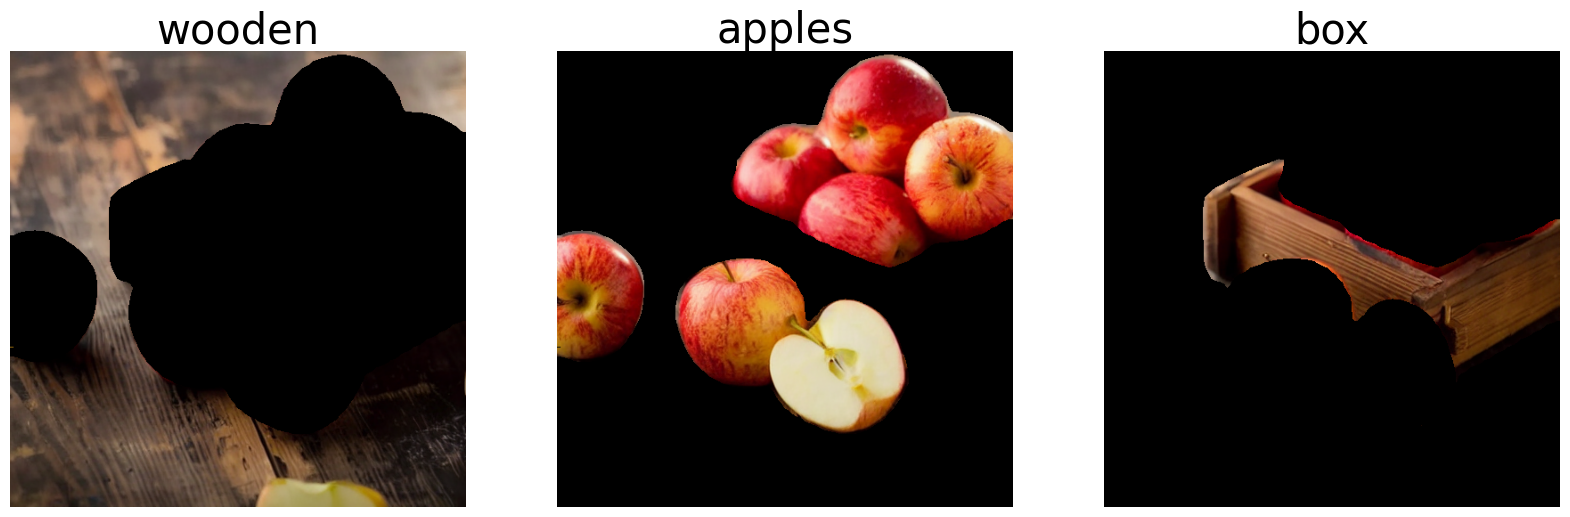

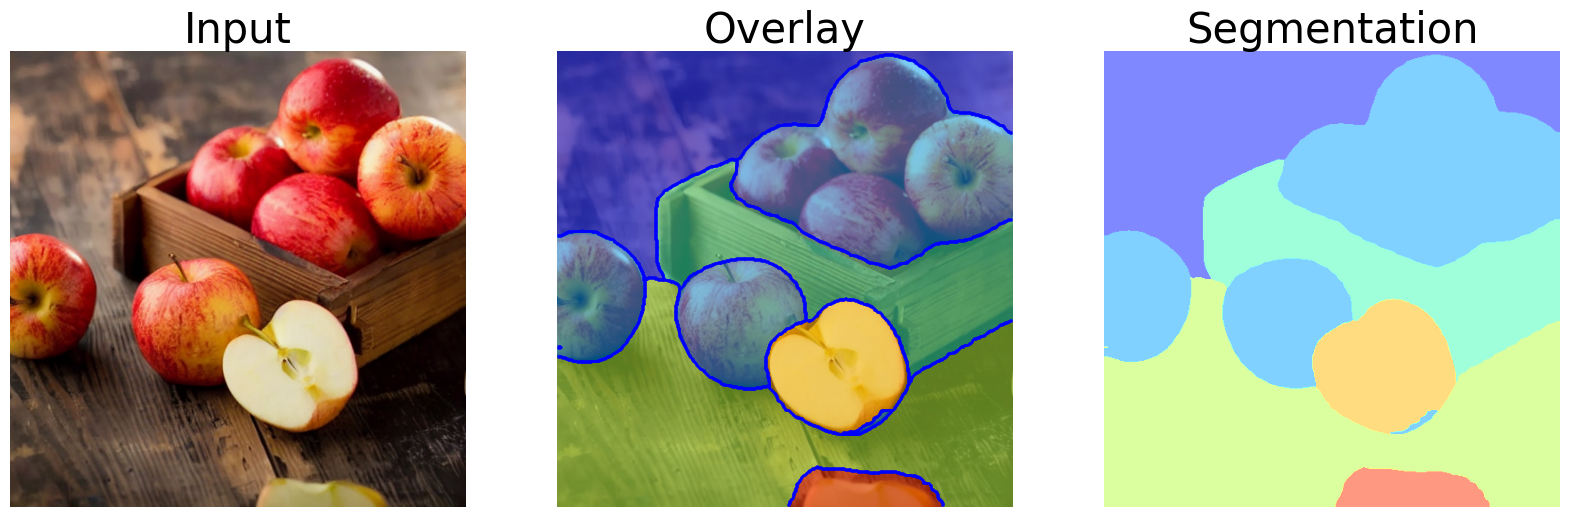

In [6]:
KL_THRESHOLD = [0.9]*3 # KL_THRESHOLD controls the merging threshold
NUM_POINTS = 16
REFINEMENT = True


with tf.device('/GPU:0'):
  segmentor = DiffSeg(KL_THRESHOLD, REFINEMENT, NUM_POINTS)
  pred = segmentor.segment(weight_64, weight_32, weight_16, weight_8) # b x 512 x 512
  if blip is not None:
    tokenized = nltk.word_tokenize(prompt)
    nouns = [(i,word) for i,(word, pos) in enumerate(nltk.pos_tag(tokenized)) if is_noun(pos)] 

  for i in range(len(images)):
    if blip is not None:
      x_weight = segmentor.aggregate_x_weights([x_weights_64[i],x_weights_32[i], x_weights_16[i], x_weights_8[i]],weight_ratio=[1.0,1.0,1.0,1.0])
      label_to_mask = segmentor.get_semantics(pred[i], x_weight[i], nouns,voting="mean")
      semantic_mask(images[i], pred[i], label_to_mask)
    vis_without_label(pred[i],images[i],num_class=len(set(pred[i].flatten())))